In [24]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Conv1D, MaxPooling1D, MaxPooling1D, GlobalMaxPooling1D
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import tensorflow as tf
import numpy as np
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
import chardet
from keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from keras.constraints import maxnorm
from tensorflow.keras.optimizers import Adam 
from keras import regularizers
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import seaborn as sb

[nltk_data] Downloading package punkt to /Users/aishwarya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aishwarya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aishwarya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
with open('../data/nlp_vader_textblob_classified_data.csv', 'rb') as f:
    enc = chardet.detect(f.read())  # or readline if the file is large
    
tweetData = pd.read_csv('../data/nlp_vader_textblob_classified_data.csv', encoding = enc['encoding'], index_col=False)
tweetData

,username,verified,followersCount,content,label,date,country,replyCount,retweetCount,likeCount,...,vader_neg,vader_neu,vader_pos,vader_comp,cleantext2,class,TextBlob_Subjectivity,TextBlob_Polarity,TextBlob_Analysis,final_class
0,HuyThanhNguyen5,False,0,@unitedstandmufc @markgoldbridge get ole again...,-1.0,2022-08-31 15:12:54,India,0,0,0,...,0.046,0.819,0.134,0.7133,g e t o l e a g a i n t o t e l l ...,-1,0.600000,0.290000,1,-1
1,guaslackjack,False,125,best goal: bruno top assists: pogba ??: cristi...,1.0,2021-09-11 15:56:21,India,0,0,0,...,0.000,0.561,0.439,0.8225,b e s t g o a l : b r u n o t o p a s ...,1,0.400000,0.533333,1,1
2,gerryrb,False,935,@lost_souls_07 @kayinfinite28 @altyred2 @utdpl...,0.0,2022-09-03 14:29:34,Argentina,1,0,1,...,0.000,0.505,0.495,0.9562,i d o n o t k n o w i s t h ...,1,0.783333,0.450000,1,0
3,rickitten_,False,9,players spurs in old trafford #mufc #muntot ht...,0.0,2022-03-12 19:14:18,India,0,0,0,...,0.000,1.000,0.000,0.0000,p l a y e r s s p u r s i n o l d t r ...,0,0.200000,0.100000,1,0
4,saboteurDS,False,278,@tancredipalmeri why on earth would #mufc pay ...,-1.0,2022-08-28 12:07:34,India,0,0,2,...,0.045,0.643,0.312,0.8072,w h y o n e a r t h w o u l d p a ...,-1,0.500000,0.500000,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97393,ChelseaEleven,False,21757,"thank you for everything, Thomas Tuchel #CFC #...",NaN,2022-09-07 09:09:44+00:00,India,0,1,4,...,0.000,0.667,0.333,0.3612,t h a n k y o u f o r e v e r y t h i n ...,1,0.000000,0.000000,0,1
97394,amber_chelsea,False,2195,@Chukwuemekaa10 thanks for the pic Carney ????...,NaN,2022-08-27 13:17:33+00:00,Zimbabwe,0,0,4,...,0.000,0.580,0.420,0.4404,t h a n k s f o r t h e p i c c a r ...,1,0.200000,0.200000,1,1
97395,Dc_Solomon2,False,143,Contacts ongoing between Chelsea and Brighton ...,NaN,2022-09-07 11:25:44+00:00,Zimbabwe,0,0,1,...,0.000,1.000,0.000,0.0000,c o n t a c t s o n g o i n g b e t w e e ...,0,0.400000,0.400000,1,0
97396,Marcus_Bryan_,False,5439,Billy Gilmour left #ChelseaFC to join Brighton...,NaN,2022-09-08 16:43:30+00:00,Argentina,1,2,24,...,0.000,0.805,0.195,0.5574,b i l l y g i l m o u r l e f t t o ...,1,0.035897,0.000000,0,1


In [4]:
labels = tweetData['final_class']
def featureEngineering(tweet):
    # Lower case tweet
    tweetMod = tweet.lower()
    # Replace URLs with a space in the message
    tweetMod = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', tweetMod)
    # Replace ticker symbols with a space. The ticker symbols are any stock symbol that starts with $.
    tweetMod = re.sub('\$[a-zA-Z0-9]*', ' ', tweetMod)
    # Replace StockTwits usernames with a space. The usernames are any word that starts with @.
    tweetMod = re.sub('\@[a-zA-Z0-9]*', ' ', tweetMod)
    # Replace everything not a letter or apostrophe with a space
    tweetMod = re.sub('[^a-zA-Z\']', ' ', tweetMod)
    # Remove single letter words
    tweetMod = ' '.join([w for w in tweetMod.split() if len(w) > 1])

    return tweetMod


# Process for all tweets
tweetData['modTweet'] = [featureEngineering(tweet) for tweet in tweetData['content']]

def lemmatizeTweet(tweet):
    words = [word for word in word_tokenize(tweet) if (word.isalpha()==1)]
    # Remove stop words
    stop = set(stopwords.words('english'))
    words = [word for word in words if (word not in stop)]
    # Lemmatize words (first noun, then verb)
    wnl = nltk.stem.WordNetLemmatizer()
    lemmatized = [wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v') for word in words]
    return " ".join(lemmatized)

tweetData['lemmatizedText'] = tweetData["modTweet"].apply(lambda x:lemmatizeTweet(x))

In [5]:
tweetData

,username,verified,followersCount,content,label,date,country,replyCount,retweetCount,likeCount,...,vader_pos,vader_comp,cleantext2,class,TextBlob_Subjectivity,TextBlob_Polarity,TextBlob_Analysis,final_class,modTweet,lemmatizedText
0,HuyThanhNguyen5,False,0,@unitedstandmufc @markgoldbridge get ole again...,-1.0,2022-08-31 15:12:54,India,0,0,0,...,0.134,0.7133,g e t o l e a g a i n t o t e l l ...,-1,0.600000,0.290000,1,-1,get ole again to tell long conversation that e...,get ole tell long conversation everything whee...
1,guaslackjack,False,125,best goal: bruno top assists: pogba ??: cristi...,1.0,2021-09-11 15:56:21,India,0,0,0,...,0.439,0.8225,b e s t g o a l : b r u n o t o p a s ...,1,0.400000,0.533333,1,1,best goal bruno top assists pogba cristiano wh...,best goal bruno top assist pogba cristiano tim...
2,gerryrb,False,935,@lost_souls_07 @kayinfinite28 @altyred2 @utdpl...,0.0,2022-09-03 14:29:34,Argentina,1,0,1,...,0.495,0.9562,i d o n o t k n o w i s t h ...,1,0.783333,0.450000,1,0,souls don't know is the honest answer but he's...,soul know honest answer definitely hard nose b...
3,rickitten_,False,9,players spurs in old trafford #mufc #muntot ht...,0.0,2022-03-12 19:14:18,India,0,0,0,...,0.000,0.0000,p l a y e r s s p u r s i n o l d t r ...,0,0.200000,0.100000,1,0,players spurs in old trafford mufc muntot,player spur old trafford mufc muntot
4,saboteurDS,False,278,@tancredipalmeri why on earth would #mufc pay ...,-1.0,2022-08-28 12:07:34,India,0,0,2,...,0.312,0.8072,w h y o n e a r t h w o u l d p a ...,-1,0.500000,0.500000,1,-1,why on earth would mufc pay for osimhen ronald...,earth would mufc pay osimhen ronaldo go better...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97393,ChelseaEleven,False,21757,"thank you for everything, Thomas Tuchel #CFC #...",NaN,2022-09-07 09:09:44+00:00,India,0,1,4,...,0.333,0.3612,t h a n k y o u f o r e v e r y t h i n ...,1,0.000000,0.000000,0,1,thank you for everything thomas tuchel cfc che...,thank everything thomas tuchel cfc chelsea
97394,amber_chelsea,False,2195,@Chukwuemekaa10 thanks for the pic Carney ????...,NaN,2022-08-27 13:17:33+00:00,Zimbabwe,0,0,4,...,0.420,0.4404,t h a n k s f o r t h e p i c c a r ...,1,0.200000,0.200000,1,1,thanks for the pic carney utc ktbffh chelseafc,thank pic carney utc ktbffh chelseafc
97395,Dc_Solomon2,False,143,Contacts ongoing between Chelsea and Brighton ...,NaN,2022-09-07 11:25:44+00:00,Zimbabwe,0,0,1,...,0.000,0.0000,c o n t a c t s o n g o i n g b e t w e e ...,0,0.400000,0.400000,1,0,contacts ongoing between chelsea and brighton ...,contact ongoing chelsea brighton graham potter...
97396,Marcus_Bryan_,False,5439,Billy Gilmour left #ChelseaFC to join Brighton...,NaN,2022-09-08 16:43:30+00:00,Argentina,1,2,24,...,0.195,0.5574,b i l l y g i l m o u r l e f t t o ...,1,0.035897,0.000000,0,1,billy gilmour left chelseafc to join brighton ...,billy gilmour leave chelseafc join brighton pl...


In [6]:
tweetData['lemmatizedText'].to_list()

['get ole tell long conversation everything wheel train good sprit amaze finally player kick manager job reporter want find word shock article get view',
 'best goal bruno top assist pogba cristiano time alive ggmu mufc manutd munnew',
 'soul know honest answer definitely hard nose businessman respect successful',
 'player spur old trafford mufc muntot',
 'earth would mufc pay osimhen ronaldo go better party unite pay another antony anyway',
 'welcome wan na see manchester unite shirt antony ready manchester unite man grow sao paulo hell mufc manchesterunited glazerssellnow',
 'finally get player give heart soul blood sweat tear unite really excite time unite fan right mufc unite utfr ggmu',
 'break code today mufc',
 'olsen ole still job ole root cause pay time relegation player lmao',
 'oh arlo graeme call muntot game peacock sure shit mufc whole game clown',
 'rabiot arnotovic unforgivable bring shit club glazer shit jim ratcliffe announce desire buy mufc fan become energize turn gl

In [7]:
train_df, test_df = train_test_split(tweetData, test_size=0.3, random_state=42)

In [9]:
train_tweets =[]
for tweet in train_df.lemmatizedText:
    train_tweets.append(tweet)
    
test_tweets =[]
for tweet in test_df.lemmatizedText:
    test_tweets.append(tweet)

In [12]:
# bag of words model
vectorizer = TfidfVectorizer()
train_tfidf_model = vectorizer.fit_transform(train_tweets)
test_tfidf_model = vectorizer.transform(test_tweets)

In [13]:
train_tfidf = pd.DataFrame(train_tfidf_model.toarray(), columns=vectorizer.get_feature_names())
train_tfidf

,aa,aaaaaaaaaaahhhhhhhhh,aaaaaaannnndddd,aaaahhh,aaaand,aaaannnnddd,aaah,aaand,aaarrgghh,aaarrrgghh,...,zurecht,zurich,zuuzee,zw,zweitliga,zx,zyech,zyiech,zynchenko,zzzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
print(vectorizer.get_feature_names())

['aa', 'aaaaaaaaaaahhhhhhhhh', 'aaaaaaannnndddd', 'aaaahhh', 'aaaand', 'aaaannnnddd', 'aaah', 'aaand', 'aaarrgghh', 'aaarrrgghh', 'aadu', 'aah', 'aakin', 'aaland', 'aaltonen', 'aamiin', 'aamm', 'aaranson', 'aaroen', 'aaron', 'aaronen', 'aaronramsdale', 'aaronson', 'aayush', 'ab', 'aba', 'ababet', 'abada', 'abafana', 'abaho', 'abandon', 'abang', 'abate', 'abba', 'abbey', 'abbinha', 'abby', 'abc', 'abcbbd', 'abcdefu', 'abcnews', 'abdul', 'abdullah', 'abeg', 'abegee', 'abegggg', 'abeh', 'abell', 'abema', 'abemajapan', 'abeokuta', 'aberdeen', 'aberdeenfc', 'aberdeentaxi', 'aberration', 'abes', 'abi', 'abidin', 'abigail', 'ability', 'abilty', 'abiola', 'abit', 'abject', 'abjectly', 'able', 'abner', 'abo', 'aboard', 'abojt', 'abortion', 'abortionrightsarehumanrights', 'abou', 'aboubakar', 'abound', 'aboutlastnight', 'aboutright', 'abouts', 'abouutttttt', 'aboveallelse', 'abraham', 'abrahamovic', 'abrahamovich', 'abrahimovich', 'abramovic', 'abramovich', 'abramovichdidnothingwrong', 'abramovi

In [17]:
cls = [LogisticRegression(),
       MultinomialNB(), 
       DecisionTreeClassifier(),
       RandomForestClassifier(n_estimators=200),
       KNeighborsClassifier(n_neighbors = 5)]

cls_name = []

In [18]:
lbl_actual = test_df.final_class
i = 0
accuracy = []
for cl in cls:
    model = cl.fit(train_tfidf_model,train_df.final_class)
    lbl_pred = model.predict(test_tfidf_model)
    a = (100*accuracy_score(lbl_pred, lbl_actual))
    a = round(a,2)
    accuracy.append(a)
    cls_name.append(cl.__class__.__name__)
    print ("{}  Accuracy Score : {}%".format(cls_name[i],a))
    print ( classification_report(lbl_pred, lbl_actual))
    i +=1

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression  Accuracy Score : 82.58%
              precision    recall  f1-score   support

          -1       0.74      0.84      0.79      8108
           0       0.92      0.83      0.87     10612
           1       0.81      0.81      0.81     10500

    accuracy                           0.83     29220
   macro avg       0.83      0.83      0.82     29220
weighted avg       0.83      0.83      0.83     29220

MultinomialNB  Accuracy Score : 71.47%
              precision    recall  f1-score   support

          -1       0.77      0.70      0.73     10228
           0       0.59      0.84      0.70      6669
           1       0.78      0.66      0.71     12323

    accuracy                           0.71     29220
   macro avg       0.71      0.73      0.71     29220
weighted avg       0.73      0.71      0.72     29220

DecisionTreeClassifier  Accuracy Score : 78.41%
              precision    recall  f1-score   support

          -1       0.69      0.74      0.71      863

([0, 1, 2, 3, 4],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

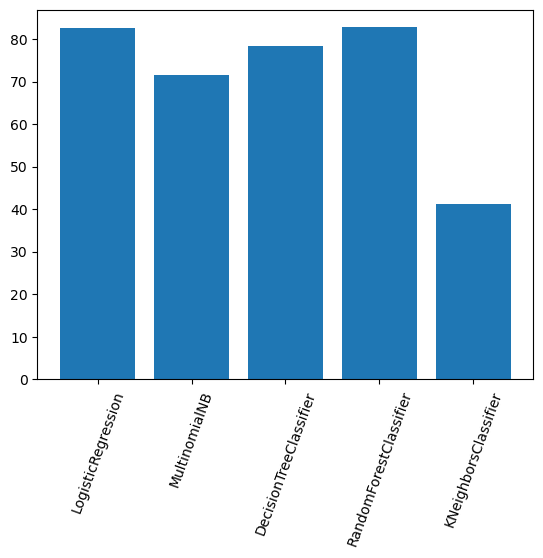

In [19]:
plt.bar(cls_name, accuracy)
plt.xticks(rotation=70)

In [20]:
lg_model = RandomForestClassifier(n_estimators=200).fit(train_tfidf_model,train_df.final_class)
lg_lbl_pred = model.predict(test_tfidf_model)

In [21]:
lg_lbl_pred_df = pd.DataFrame({'tweet_id': test_df.username,
                            'text' : test_df.content,
                            'lg_reg' : lg_lbl_pred})
lg_lbl_pred_df.head()

,tweet_id,text,lg_reg
43756,tomwaugh79,@alexshawespn forgetting frank swift was on th...,1
20000,darkinark,@lg_mcfc mahrez came on from bench but yeah,0
67864,SamNicholles,one of the worst penalties i’ve ever saw that ...,0
61176,Yousef_AFC_11,no red card in my book https://t.co/wosd4jmqhq,0
90320,chelseanewsonly,(Video): Aubameyang’s first words as a Chelsea...,0


In [22]:
lg_lbl_pred_df

,tweet_id,text,lg_reg
43756,tomwaugh79,@alexshawespn forgetting frank swift was on th...,1
20000,darkinark,@lg_mcfc mahrez came on from bench but yeah,0
67864,SamNicholles,one of the worst penalties i’ve ever saw that ...,0
61176,Yousef_AFC_11,no red card in my book https://t.co/wosd4jmqhq,0
90320,chelseanewsonly,(Video): Aubameyang’s first words as a Chelsea...,0
...,...,...,...
68281,AfcMoustache,@tbahnson @afcreport14 @arsenal arteta didn’t ...,1
85021,manicmonologue1,no loyalty left in football like wth\n#Chelsea...,0
27496,Cameron_MCFC_,@edmund_kjq @activegooner @ozilthings @mcfcrya...,0
89172,AdetayoDaniel12,Tbh if we don't win this match TT should be co...,0


 0    25185
 1     2615
-1     1420
Name: lg_reg, dtype: int64


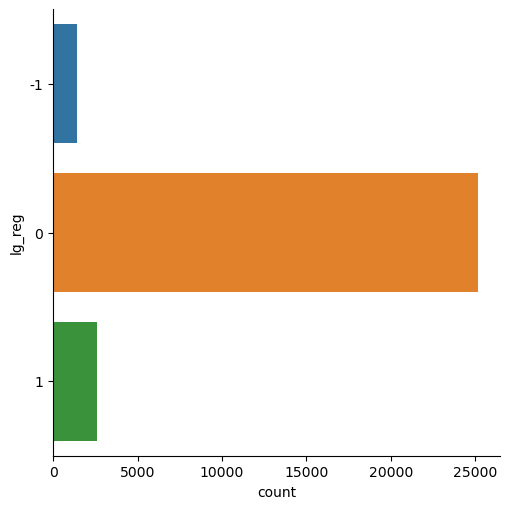

In [25]:
print(lg_lbl_pred_df["lg_reg"].value_counts())
sb.catplot(y = "lg_reg", data = lg_lbl_pred_df, kind = "count")

In [26]:
lg_model = LogisticRegression().fit(train_tfidf_model,train_df.final_class)
lg_lbl_pred = model.predict(test_tfidf_model)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [27]:
lg_lbl_pred_df = pd.DataFrame({'tweet_id': test_df.username,
                            'text' : test_df.content,
                            'lg_reg' : lg_lbl_pred})
lg_lbl_pred_df.head()

,tweet_id,text,lg_reg
43756,tomwaugh79,@alexshawespn forgetting frank swift was on th...,1
20000,darkinark,@lg_mcfc mahrez came on from bench but yeah,0
67864,SamNicholles,one of the worst penalties i’ve ever saw that ...,0
61176,Yousef_AFC_11,no red card in my book https://t.co/wosd4jmqhq,0
90320,chelseanewsonly,(Video): Aubameyang’s first words as a Chelsea...,0


In [28]:
lg_lbl_pred_df

,tweet_id,text,lg_reg
43756,tomwaugh79,@alexshawespn forgetting frank swift was on th...,1
20000,darkinark,@lg_mcfc mahrez came on from bench but yeah,0
67864,SamNicholles,one of the worst penalties i’ve ever saw that ...,0
61176,Yousef_AFC_11,no red card in my book https://t.co/wosd4jmqhq,0
90320,chelseanewsonly,(Video): Aubameyang’s first words as a Chelsea...,0
...,...,...,...
68281,AfcMoustache,@tbahnson @afcreport14 @arsenal arteta didn’t ...,1
85021,manicmonologue1,no loyalty left in football like wth\n#Chelsea...,0
27496,Cameron_MCFC_,@edmund_kjq @activegooner @ozilthings @mcfcrya...,0
89172,AdetayoDaniel12,Tbh if we don't win this match TT should be co...,0


 0    25185
 1     2615
-1     1420
Name: lg_reg, dtype: int64


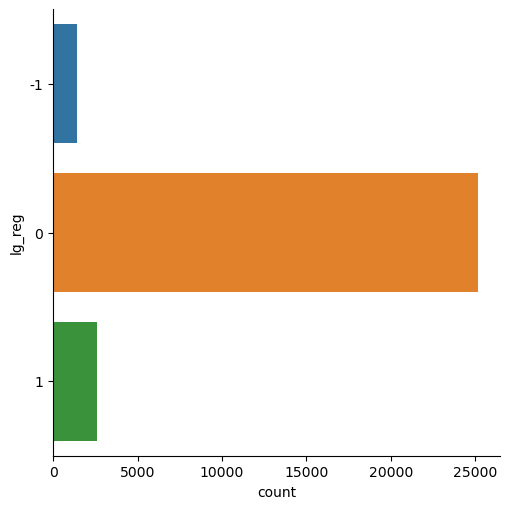

In [29]:
print(lg_lbl_pred_df["lg_reg"].value_counts())
sb.catplot(y = "lg_reg", data = lg_lbl_pred_df, kind = "count")

In [30]:
lg_model = DecisionTreeClassifier().fit(train_tfidf_model,train_df.final_class)
lg_lbl_pred = model.predict(test_tfidf_model)

In [31]:
lg_lbl_pred_df = pd.DataFrame({'tweet_id': test_df.username,
                            'text' : test_df.content,
                            'lg_reg' : lg_lbl_pred})
lg_lbl_pred_df.head()

,tweet_id,text,lg_reg
43756,tomwaugh79,@alexshawespn forgetting frank swift was on th...,1
20000,darkinark,@lg_mcfc mahrez came on from bench but yeah,0
67864,SamNicholles,one of the worst penalties i’ve ever saw that ...,0
61176,Yousef_AFC_11,no red card in my book https://t.co/wosd4jmqhq,0
90320,chelseanewsonly,(Video): Aubameyang’s first words as a Chelsea...,0


In [32]:
lg_lbl_pred_df

,tweet_id,text,lg_reg
43756,tomwaugh79,@alexshawespn forgetting frank swift was on th...,1
20000,darkinark,@lg_mcfc mahrez came on from bench but yeah,0
67864,SamNicholles,one of the worst penalties i’ve ever saw that ...,0
61176,Yousef_AFC_11,no red card in my book https://t.co/wosd4jmqhq,0
90320,chelseanewsonly,(Video): Aubameyang’s first words as a Chelsea...,0
...,...,...,...
68281,AfcMoustache,@tbahnson @afcreport14 @arsenal arteta didn’t ...,1
85021,manicmonologue1,no loyalty left in football like wth\n#Chelsea...,0
27496,Cameron_MCFC_,@edmund_kjq @activegooner @ozilthings @mcfcrya...,0
89172,AdetayoDaniel12,Tbh if we don't win this match TT should be co...,0


 0    25185
 1     2615
-1     1420
Name: lg_reg, dtype: int64


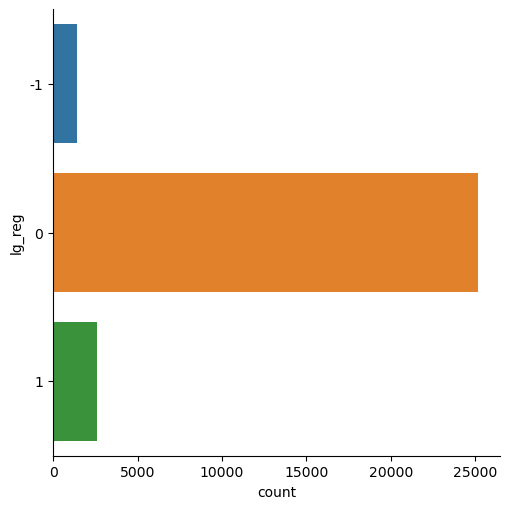

In [33]:
print(lg_lbl_pred_df["lg_reg"].value_counts())
sb.catplot(y = "lg_reg", data = lg_lbl_pred_df, kind = "count")